In [1]:
import matplotlib.pyplot as plt 
import json 
from collections import defaultdict

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

subfolders = ['all', 'concept', 'token', 'raw']
task_list = [
    'capital-common-countries', 'capital-world', 'currency',
    'city-in-state', 'family', 'gram1-adjective-to-adverb',
    'gram2-opposite', 'gram3-comparative', 'gram4-superlative',
    'gram5-present-participle', 'gram6-nationality-adjective',
    'gram7-past-tense', 'gram8-plural', 'gram9-plural-verbs'
]

In [2]:
# load the dataset
def get_number_neighbors(task):
    with open(f'../data/word2vec/questions-words.txt', 'r') as f:
        stuff = f.read()
    categories = {s.split('\n')[0] : s.split('\n')[1:] for s in stuff.split(': ')[1:]}
    categories = {k : [s for s in v if s != ''] for k, v in categories.items()}
    this_task = categories[task]

    # for this task, get representations for all the neighbors.
    neighbors = set([w for l in this_task for w in l.split(' ')])
    return len(neighbors)

# Nearest-Neighbor Accuracy Plots (Figure 1, 2)

In [3]:
import json 
from collections import defaultdict

def nn_acc_word2vec(with_prefix=True, save_fname=""):
    settings = defaultdict(dict)

    colors = {
        'all' : 'green',
        'concept' : 'indianred',
        'token' : 'cornflowerblue',
        'raw' : 'tab:orange'
    }

    subfolder = "with_prefix" if with_prefix else "no_prefix"

    for setting in colors.keys():
        results = defaultdict(dict)
        for task in task_list:
            for layer in range(32):
                try:
                    fname = f'layer{layer}_results.json'
                    # if setting == 'token': # TODO holdover from bug? 
                    #     fname = f'layer{layer}_rankFalse_results.json'
                    with open(f'../cache/parallelograms/word2vec/{subfolder}/{setting}/{task}/{fname}', 'r') as f:
                        results[task][layer] = json.load(f)
                except FileNotFoundError:
                    pass 
        settings[setting] = results

    skylines = {}
    for task in task_list:
        with open(f'../cache/skylines/{task}_word2vec.json', 'r') as f:
            skylines[task] = json.load(f)['acc']

    fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,10))
    for task, ax in zip(task_list, axs.reshape((15,))):
        ax.set_title(task)
        ax.hlines(1 / get_number_neighbors(task), 0, 31, linestyles='dotted', colors='gray')
        for setting, res_dict in settings.items():
            try:
                line = [res_dict[task][l]['nn_acc'] for l in res_dict[task].keys()]
                ax.plot(res_dict[task].keys(), line, c=colors[setting], label=setting)  
                ax.hlines(skylines[task], 0, max(res_dict[task].keys()), linestyles='dotted', colors='skyblue')
                ax.set_ylim(0, 1.05)
            except KeyError:
                print(f'missing {setting} for', task)
            
    axs[0, 0].legend()
    for r in range(3):
        axs[r, 0].set_ylabel('Nearest Neighbor Acc.')
    for c in range(5):
        axs[-1, c].set_xlabel('Layer')

    if with_prefix:
        plt.suptitle('Word2Vec Dataset: With Prefixes')
    else:
        plt.suptitle('Word2Vec Dataset: Without Any Prefixes')
    plt.tight_layout()
    if len(save_fname) > 0:
        plt.savefig(save_fname, dpi=300)
    else:
        plt.show()

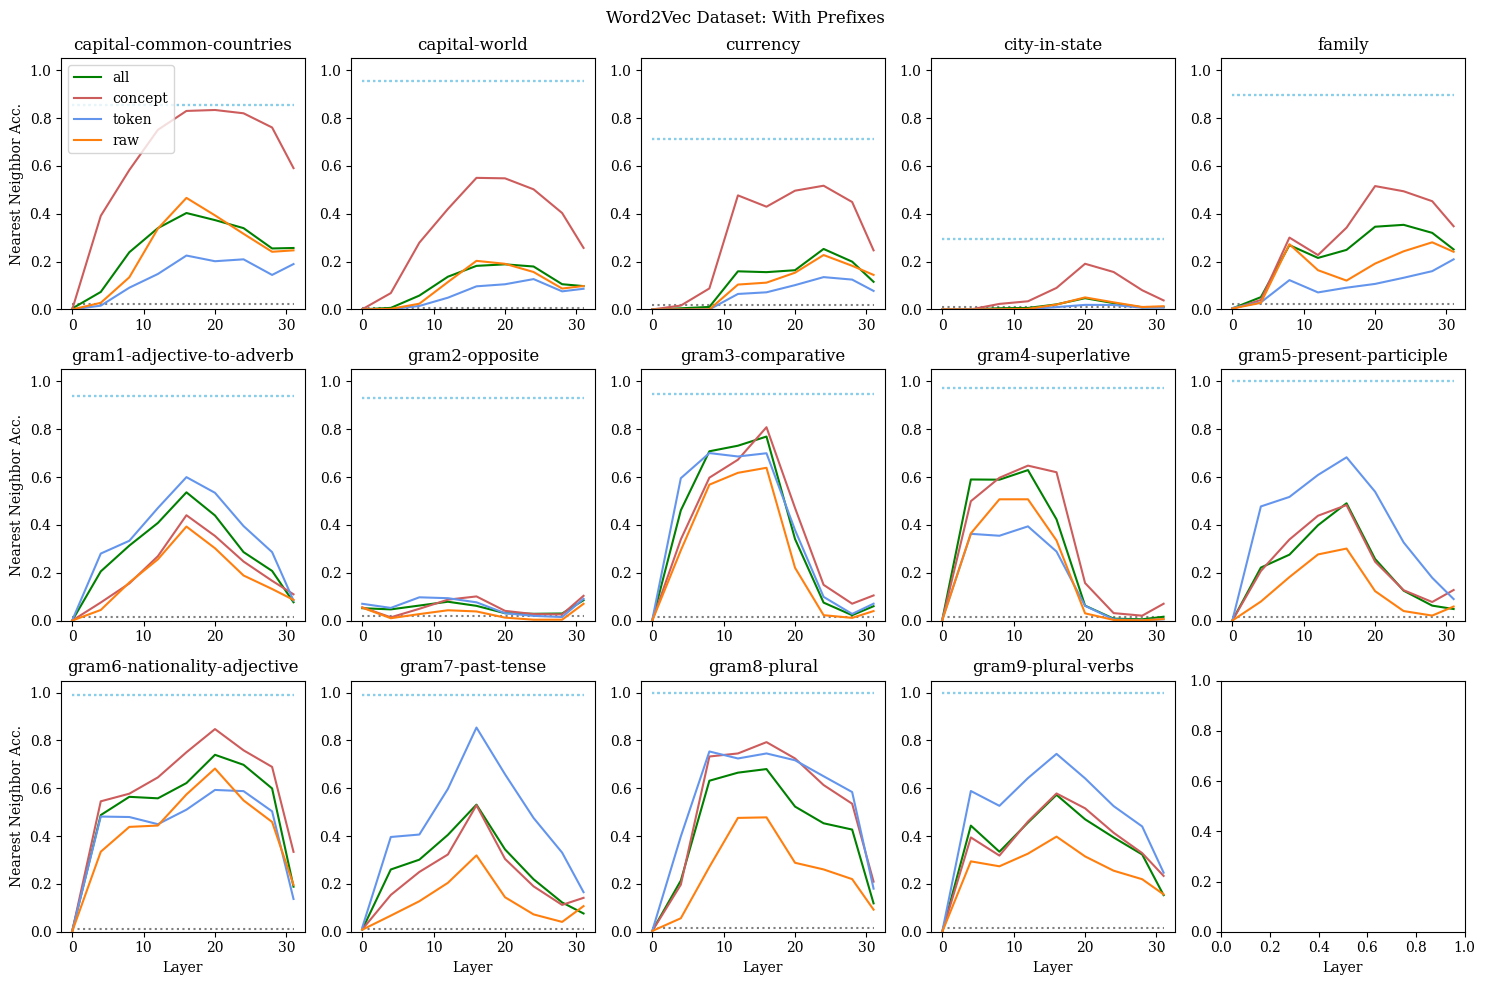

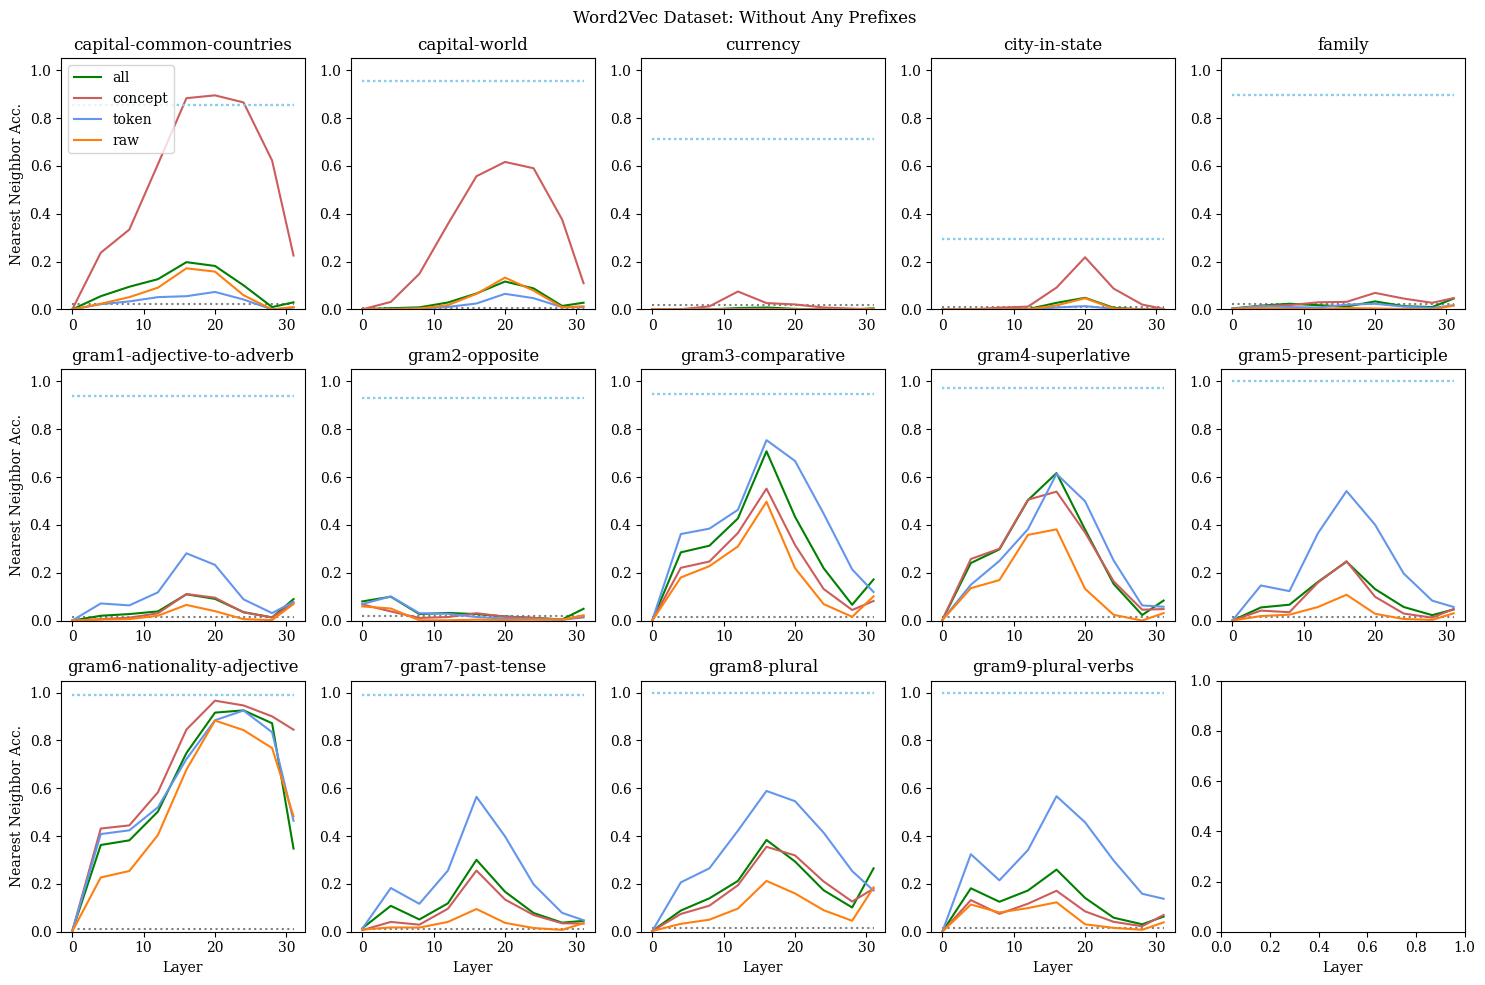

In [4]:
nn_acc_word2vec(with_prefix=True, save_fname="../figures/word2vec_nn_withprefix.png")
nn_acc_word2vec(with_prefix=False, save_fname="../figures/word2vec_nn_noprefix.png")

# plot nn acc for fv tasks

In [5]:
def get_number_neighbors_fv(task):
    with open(f'../data/fvs/{task}.txt', 'r') as f:
        stuff = f.read()
    this_task = stuff.split(': ')[1:]
    # for this task, get representations for all the neighbors.
    neighbors = set([w for l in this_task for w in l.split('\t')])
    return len(neighbors)

In [6]:
import json 
import os 
from collections import defaultdict

def nn_acc_fv(with_prefix=True, save_fname=""):
    settings = defaultdict(dict)

    colors = {
        'all' : 'green',
        'concept' : 'indianred',
        'token' : 'cornflowerblue',
        'raw' : 'tab:orange'
    }

    subfolder = "with_prefix" if with_prefix else "no_prefix"
    task_list = os.listdir(f'../cache/parallelograms/fvs/{subfolder}/concept/')

    skylines = {}
    for task in task_list:
        with open(f'../cache/skylines/{task}_fvs.json', 'r') as f:
            skylines[task] = json.load(f)['acc']

    for setting in colors.keys():
        results = defaultdict(dict)
        for task in task_list:
            for layer in range(32):
                try:
                    fname = f'layer{layer}_results.json'
                    # if setting == 'token':
                    #     fname = f'layer{layer}_rankFalse_results.json'
                    with open(f'../cache/parallelograms/fvs/{subfolder}/{setting}/{task}/{fname}', 'r') as f:
                        results[task][layer] = json.load(f)
                except FileNotFoundError:
                    pass 
        settings[setting] = results
    
    fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(16,16))
    for task, ax in zip(task_list, axs.reshape((30,))):
        ax.set_title(task) 
        ax.hlines(1 / get_number_neighbors_fv(task), 0, 31, linestyles='dotted', colors='gray')
        for setting, res_dict in settings.items():
            try:
                line = [res_dict[task][l]['nn_acc'] for l in res_dict[task].keys()]
                ax.plot(res_dict[task].keys(), line, c=colors[setting], label=setting)  
                ax.hlines(skylines[task], 0, 31, linestyles='dotted', colors='skyblue')
                ax.set_ylim(0, 1.05)
            except KeyError:
                print(f'missing {setting} for', task)

    axs[0, 0].legend()
    for r in range(6):
        axs[r, 0].set_ylabel('Nearest Neighbor Acc.')
    for c in range(5):
        axs[-1, c].set_xlabel('Layer')

    if with_prefix:
        plt.suptitle('Function Vector Tasks: With Prefix\n')
    else:
        plt.suptitle('Function Vector Tasks: Without Any Prefix\n')
    plt.tight_layout()

    if len(save_fname) > 0:
        plt.savefig(save_fname, dpi=300)
    else:
        plt.show()
    

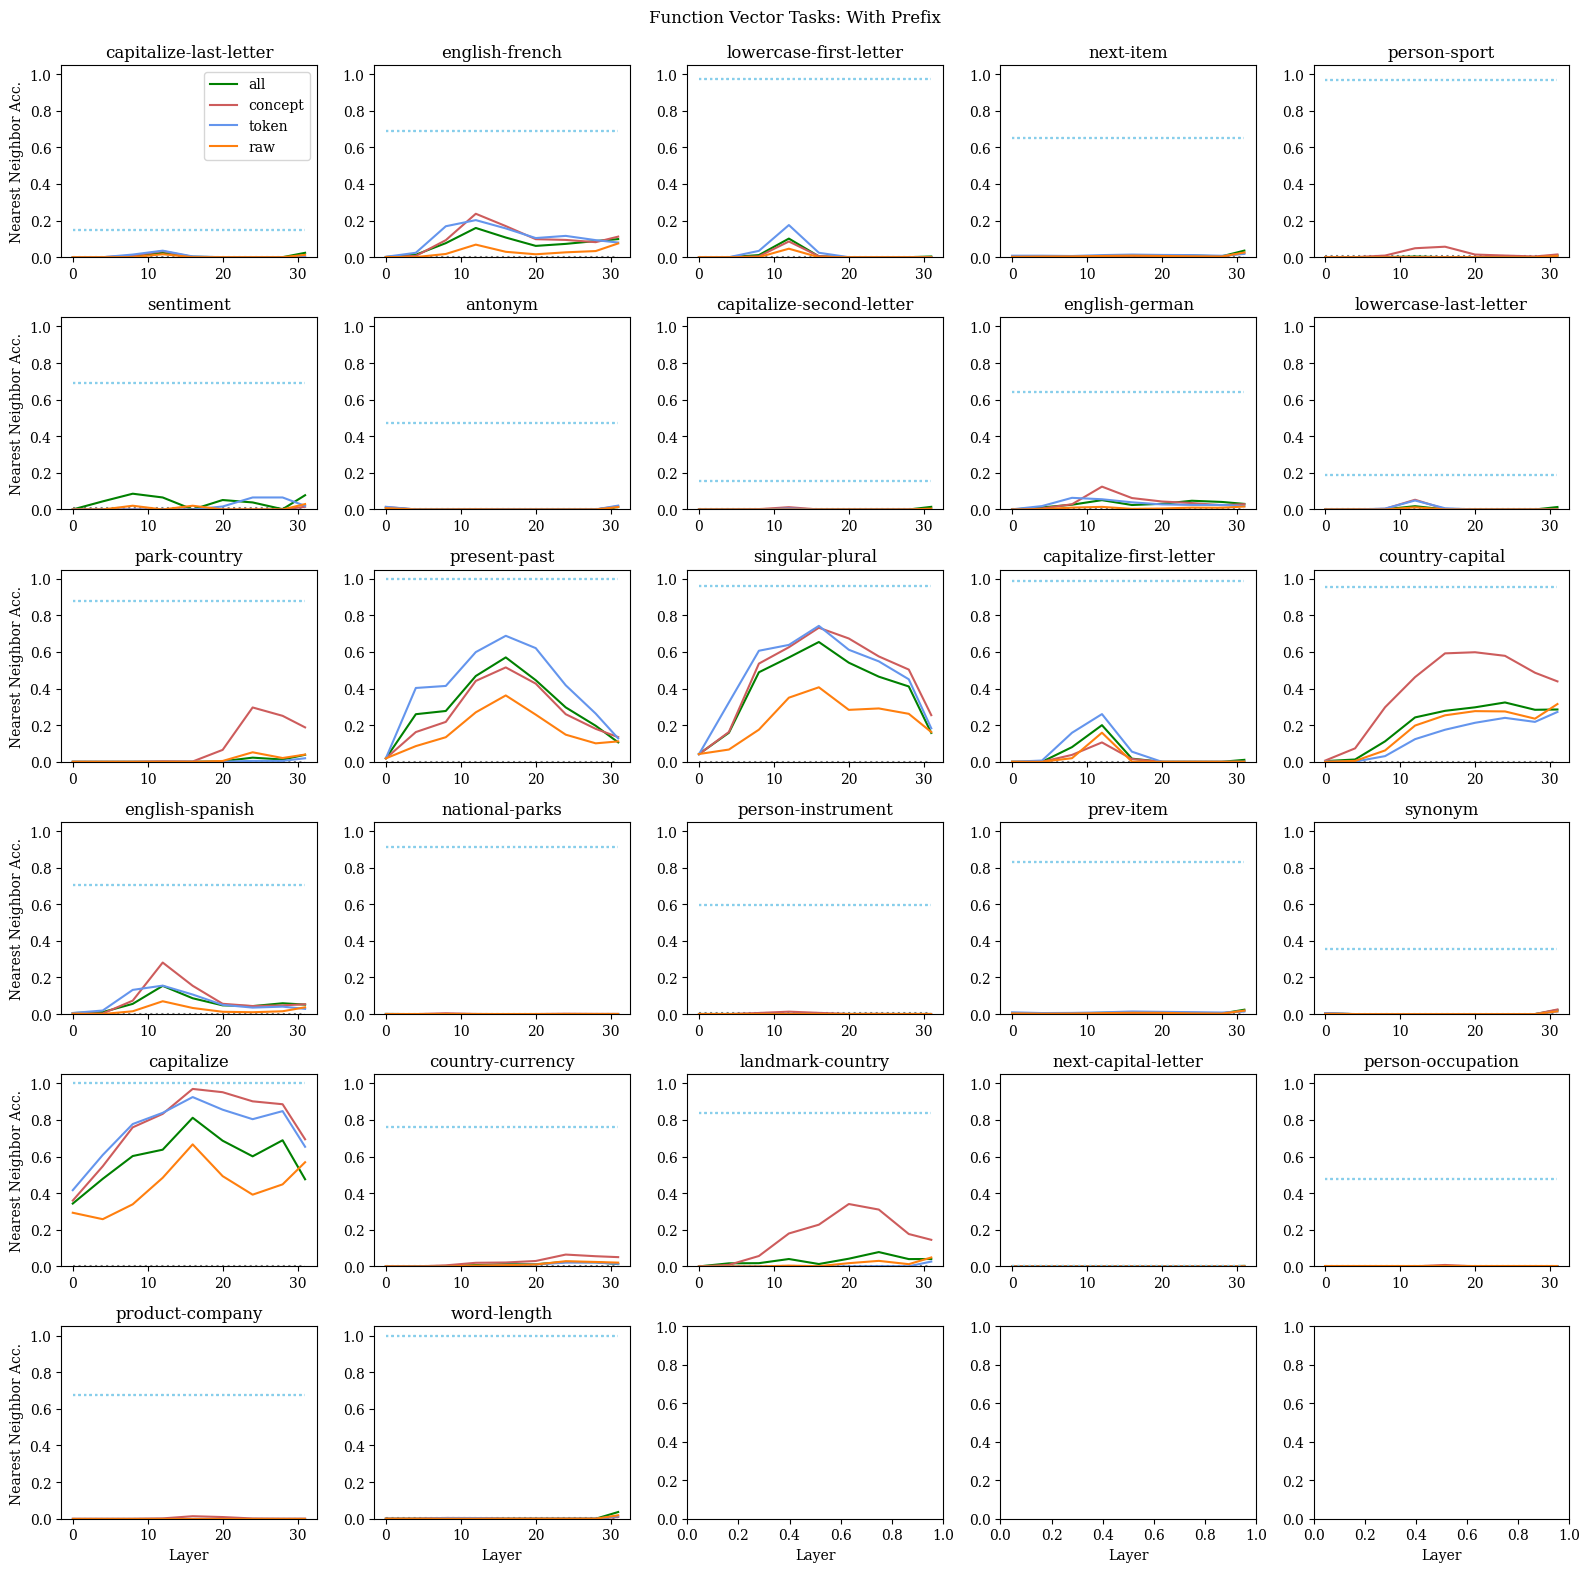

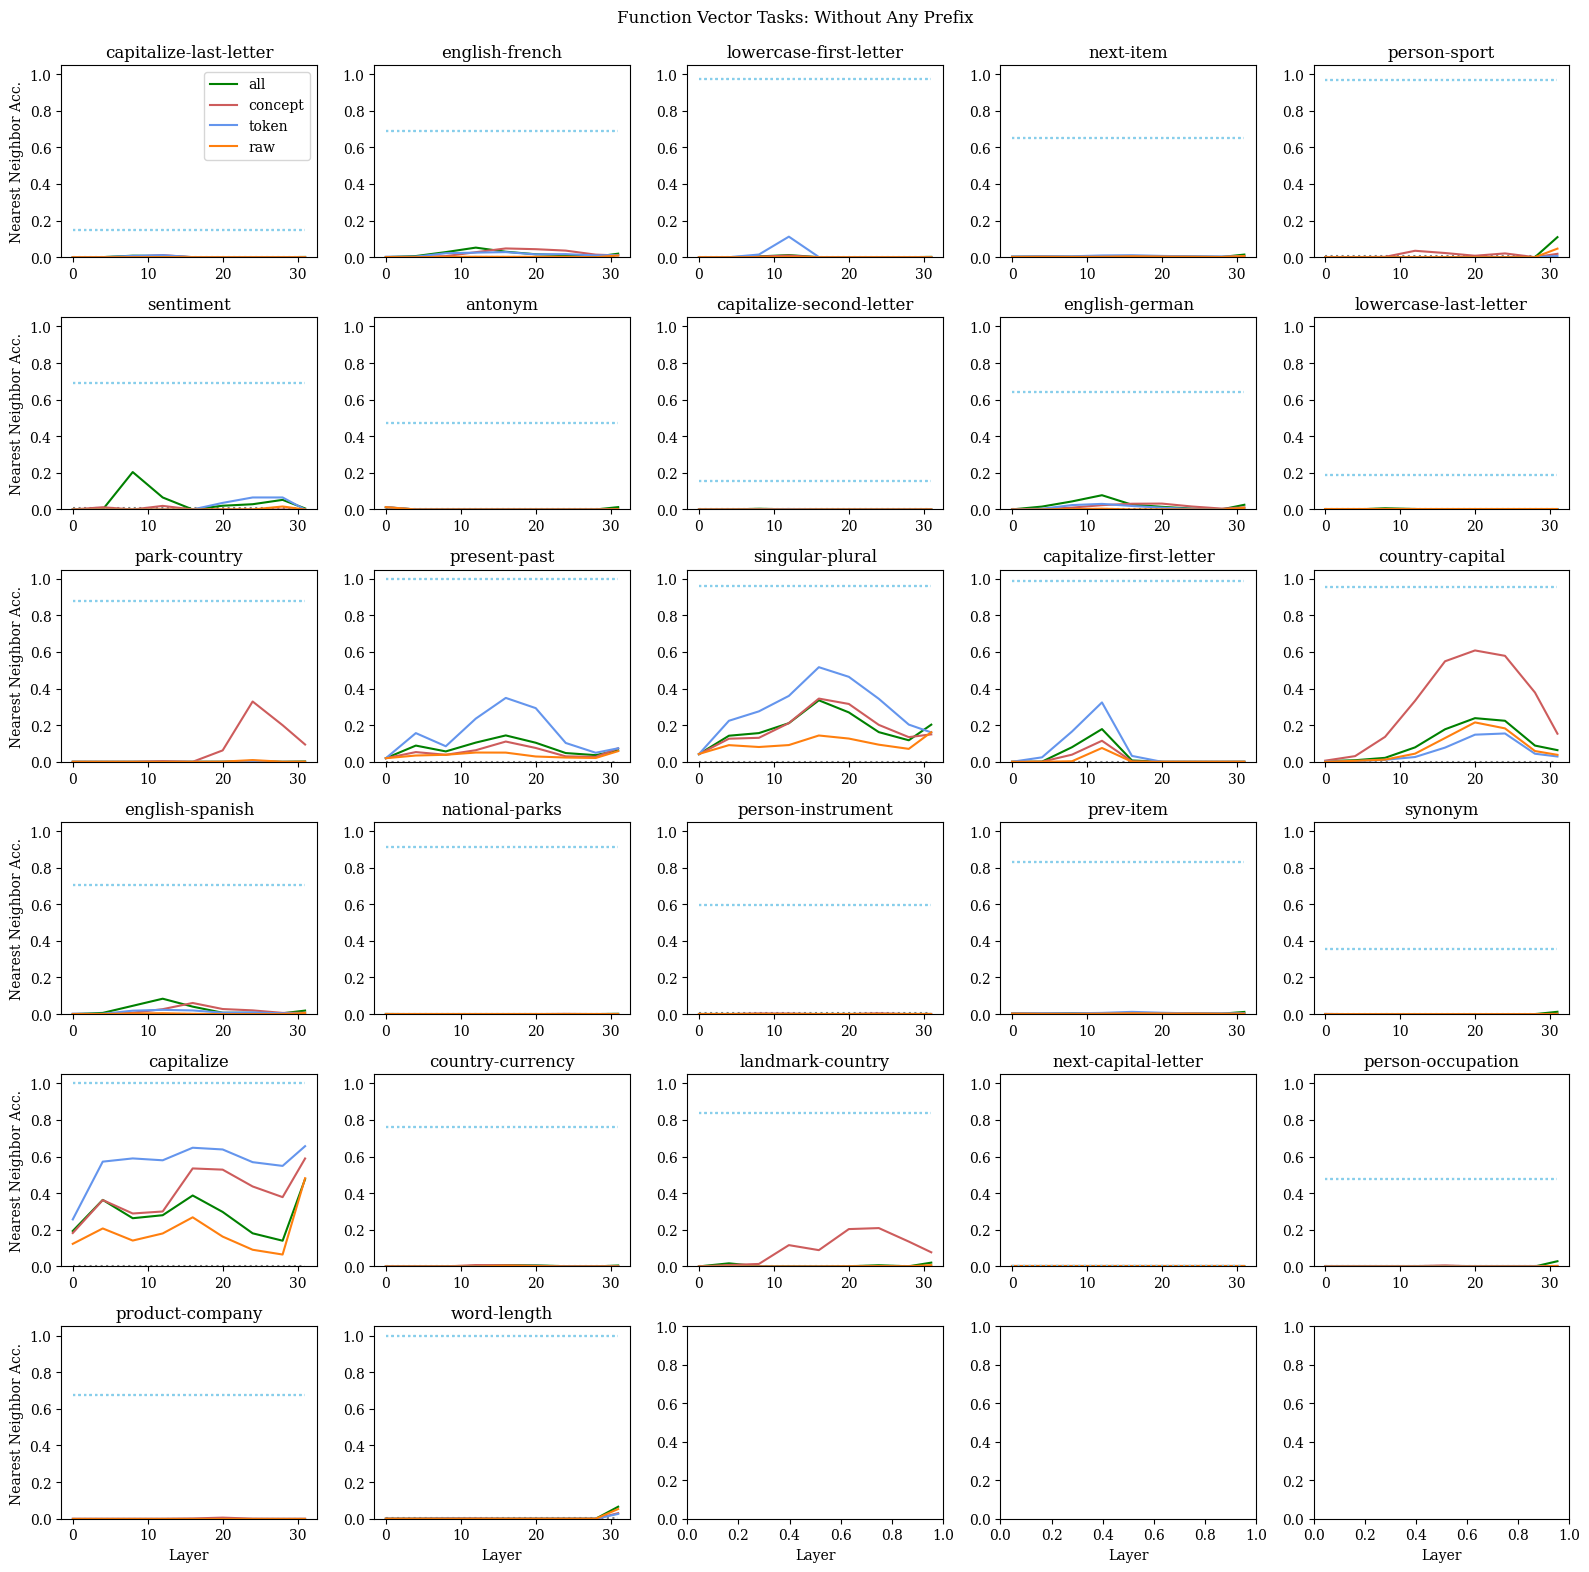

In [7]:
nn_acc_fv(with_prefix=True, save_fname="../figures/fvs_nn_withprefix.png")
nn_acc_fv(with_prefix=False, save_fname="../figures/fvs_nn_noprefix.png")

# Individual Plots (Figure 1)

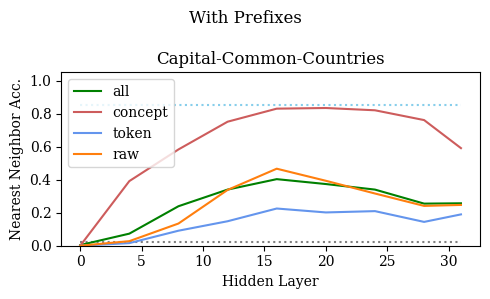

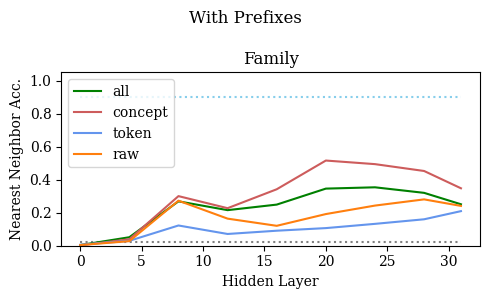

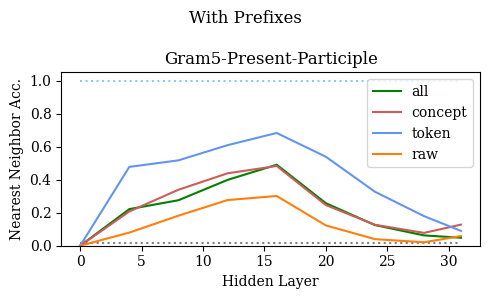

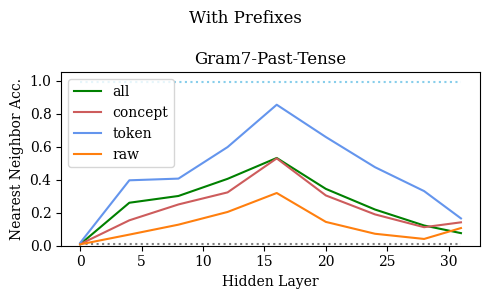

In [8]:
import json
import matplotlib.pyplot as plt 
from collections import defaultdict

settings = defaultdict(dict)

colors = {
    'all' : 'green',
    'concept' : 'indianred',
    'token' : 'cornflowerblue',
    'raw' : 'tab:orange'
}

def single_plot(task):
    with open(f'../cache/skylines/{task}_word2vec.json', 'r') as f:
        skyline = json.load(f)['acc']

    for setting in colors.keys():
        results = defaultdict(dict)
        for layer in range(32):
            try:
                fname = f'layer{layer}_results.json'
                with open(f'../cache/parallelograms/word2vec/with_prefix/{setting}/{task}/{fname}', 'r') as f:
                    results[task][layer] = json.load(f)
            except FileNotFoundError:
                pass 
        settings[setting] = results

    # overview
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

    ax.hlines(1 / get_number_neighbors(task), 0, 31, linestyles='dotted', colors='gray')
    ax.hlines(skyline, 0, 31, linestyles='dotted', colors='skyblue')
    for setting, res_dict in settings.items():
        try:
            line = [res_dict[task][l]['nn_acc'] for l in res_dict[task].keys()]
            ax.plot(res_dict[task].keys(), line, c=colors[setting], label=setting)  
        except KeyError:
            print(f'missing {setting} for', task)
        
    ax.set_title(task.title())

    ax.set_ylabel('Nearest Neighbor Acc.')
    ax.set_xlabel('Hidden Layer')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.suptitle('With Prefixes')
    plt.tight_layout()
    plt.savefig(f'../figures/singles/{task}_withprefix.png', dpi=300)

single_plot("capital-common-countries")
single_plot("family")
single_plot("gram5-present-participle")
single_plot("gram7-past-tense")

# Rank-Wise Plots (Figure 3)

In [9]:
# TODO clean up this code and stuff 
import json 
rank_results = []
for rank in [8, 16, 32, 64, 128, 256, 512]:
    with open(f'../cache/parallelograms/word2vec/no_prefix/concept/capital-common-countries/layer20_rank{rank}_results.json', 'r') as f:
        rank_results.append(json.load(f)['nn_acc'])

In [10]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

import json
superfolder = 'no_prefix'

def plot_task_ranks(task, dataset, layer, superfolder):
    with open(f'../cache/skylines/{task}_{dataset}.json', 'r') as f:
        skyline = json.load(f)['acc']

    ranks = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    plot_lines = {}
    for head_order in ['concept', 'token', 'all']: 
        nn_accs = []
        for r in ranks: 
            if r != 4096: 
                with open(f'../cache/parallelograms/{dataset}/{superfolder}/{head_order}/{task}/layer{layer}_rank{r}_results.json', 'r') as f:
                    asdf = json.load(f)
            else:
                with open(f'../cache/parallelograms/{dataset}/{superfolder}/{head_order}/{task}/layer{layer}_results.json', 'r') as f:
                    asdf = json.load(f)
            nn_accs.append(asdf['nn_acc'])
        plot_lines[head_order] = nn_accs

    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))

    ax.hlines(skyline, 0, 4096, colors='skyblue', linestyles='dotted')

    plt.plot(ranks, plot_lines['concept'], color='indianred', label='concept')
    plt.scatter(ranks, plot_lines['concept'], color='indianred', marker='x')

    plt.plot(ranks, plot_lines['token'], color='cornflowerblue', label='token')
    plt.scatter(ranks, plot_lines['token'], color='cornflowerblue', marker='x')

    plt.plot(ranks, plot_lines['all'], color='green', label='all')
    plt.scatter(ranks, plot_lines['all'], color='green', marker='x')

    plt.xscale('log')
    plt.xticks(ranks, ranks)
    plt.xlabel(f'Rank of OV Matrix')
    plt.ylabel(f'Nearest Neighbor Accuracy')
    plt.title(task)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../figures/ranks/{task}_layer{layer}.png', dpi=300)

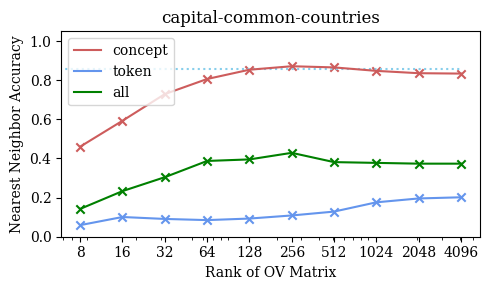

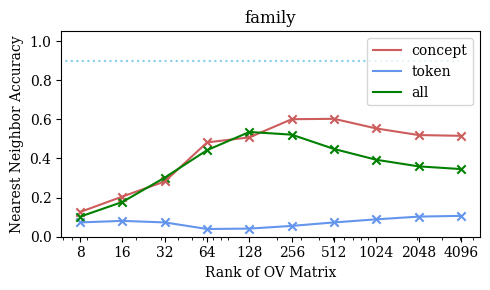

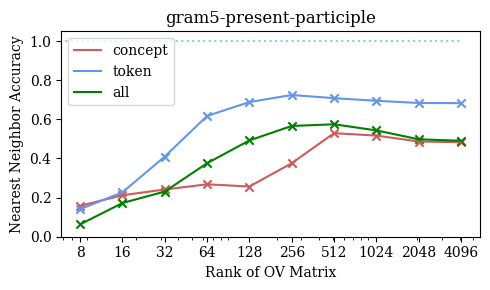

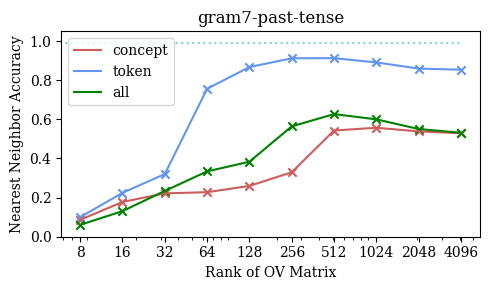

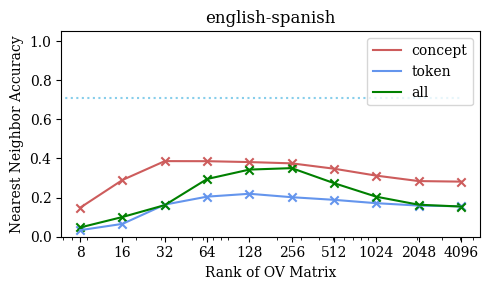

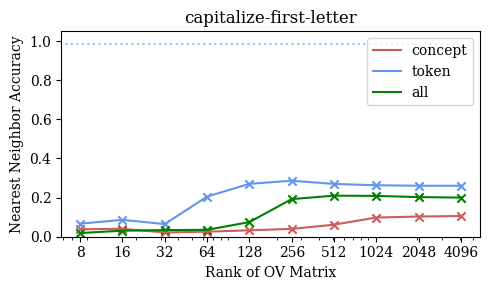

In [11]:
plot_task_ranks('capital-common-countries', 'word2vec', 20, 'with_prefix')
plot_task_ranks('family', 'word2vec', 20, 'with_prefix')
plot_task_ranks('gram5-present-participle', 'word2vec', 16, 'with_prefix')
plot_task_ranks('gram7-past-tense', 'word2vec', 16, 'with_prefix')
plot_task_ranks('english-spanish', 'fvs', 12, 'with_prefix')
plot_task_ranks('capitalize-first-letter', 'fvs', 12, 'with_prefix')